# Imports

In [1]:
import pandas as pd

from ForecastEvaluator import ForecastEvaluator
from _config import PATH_TO_CONFIG
from data_loader import MyDataLoader
from my_config import load_config, MyConfig

# Load (Preprocessed Step 1) DTU Solar Station data

In [2]:
my_config: MyConfig = load_config(r'D:\Jetbrains\Python\Projects\solar_irradiance_nowcasting\configs\dni_only\dni_lag_60_1440_2880.json')
data_loader = MyDataLoader(my_config)
data_loader.load_data()
data_loader.reindex_full_range()
data_loader.lag_features()
data_loader.prepare_df(drop_solar_altitude_below_0=True, drop_nan=True)
df = data_loader.get_df()

# mask = df.isna().values
# # make all nan values zero
# df.fillna(0, inplace=True)
display(df.head())

,DNI,DNI_lag_60,DNI_lag_1440,DNI_lag_2880
2020-01-03 07:42:00,0.0,0.020053,0.034206,0.0
2020-01-03 07:43:00,0.0,0.048371,0.042470,0.0
2020-01-03 07:44:00,0.0,0.043649,0.011798,0.0
2020-01-03 07:45:00,0.0,0.036572,0.041292,0.0
2020-01-03 07:46:00,0.0,0.063702,0.030672,0.0


# ARIMA model

In [3]:
data_loader.get_target_names()

['DNI']

In [4]:
df[data_loader.get_feature_names()]

,DNI_lag_60,DNI_lag_1440,DNI_lag_2880
2020-01-03 07:42:00,0.020053,0.034206,0.0
2020-01-03 07:43:00,0.048371,0.042470,0.0
2020-01-03 07:44:00,0.043649,0.011798,0.0
2020-01-03 07:45:00,0.036572,0.041292,0.0
2020-01-03 07:46:00,0.063702,0.030672,0.0
...,...,...,...
2024-12-30 14:38:00,0.000000,0.000000,0.0
2024-12-30 14:39:00,0.000000,0.000000,0.0
2024-12-30 14:40:00,0.000000,0.000000,0.0
2024-12-30 14:41:00,0.000000,0.000000,0.0


In [5]:
import statsmodels.api as sm
model = sm.OLS(df[data_loader.get_target_names()], df[data_loader.get_feature_names()], missing='drop')
res_ols = model.fit()

print(res_ols.summary())
# res_ols.params['y_lag60'] is your φ60


                                 OLS Regression Results                                
Dep. Variable:                    DNI   R-squared (uncentered):                   0.698
Model:                            OLS   Adj. R-squared (uncentered):              0.698
Method:                 Least Squares   F-statistic:                          9.948e+05
Date:                Tue, 03 Jun 2025   Prob (F-statistic):                        0.00
Time:                        13:35:07   Log-Likelihood:                     -8.8341e+06
No. Observations:             1290463   AIC:                                  1.767e+07
Df Residuals:                 1290460   BIC:                                  1.767e+07
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

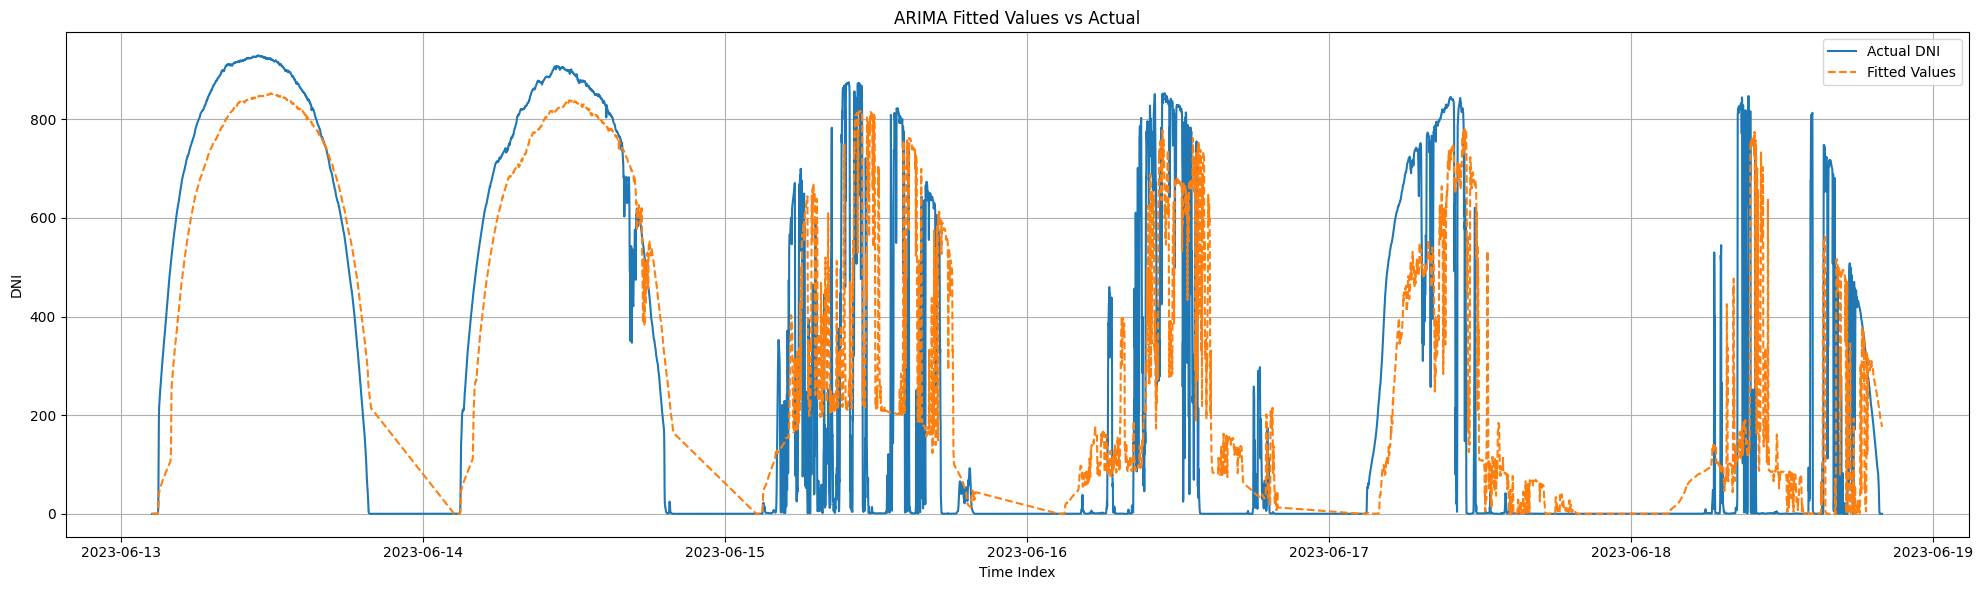

In [6]:
start = '2023-06-13'
end = '2023-06-18'
fitted_values = res_ols.fittedvalues
# Plot fitted values
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.plot(df.loc[start:end].index, df.loc[start:end]['DNI'], label='Actual DNI')
plt.plot(df.loc[start:end].index, fitted_values.loc[start:end], label='Fitted Values', linestyle='--')
plt.title('ARIMA Fitted Values vs Actual')
plt.xlabel('Time Index')
plt.ylabel('DNI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
from data_loader import SPLIT
fitted_values.loc[data_loader.get_split(SPLIT.TEST).index]

2024-01-01 07:43:00    0.003187
2024-01-01 07:44:00    0.001952
2024-01-01 07:45:00    0.003910
2024-01-01 07:46:00    0.004253
2024-01-01 07:47:00    0.006069
                         ...   
2024-12-30 14:38:00    0.000000
2024-12-30 14:39:00    0.000000
2024-12-30 14:40:00    0.000000
2024-12-30 14:41:00    0.000000
2024-12-30 14:42:00    0.000000
Length: 244869, dtype: float64

In [8]:
test_predictions_df = pd.DataFrame({
    '59': fitted_values.loc[data_loader.get_split(SPLIT.TEST).index]
}, index=data_loader.get_split(SPLIT.TEST).index)

test_predictions_df.to_pickle('OLS_performance_predictions_df.pkl')
test_predictions_df


,59
2024-01-01 07:43:00,0.003187
2024-01-01 07:44:00,0.001952
2024-01-01 07:45:00,0.003910
2024-01-01 07:46:00,0.004253
2024-01-01 07:47:00,0.006069
...,...
2024-12-30 14:38:00,0.000000
2024-12-30 14:39:00,0.000000
2024-12-30 14:40:00,0.000000
2024-12-30 14:41:00,0.000000
